In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Orientation Control
The state vector has the position and velocity vectors
$$
\mathbf{x}= \begin{bmatrix}
 \mathbf{\theta}
\\ 
\mathbf{\dot \theta}
\end{bmatrix}.
$$
The robot force $f$ generates a torque
$$
\tau = l f.
$$
The control input is the force $f=u$.

Using the Euler equation, we can derive the dynamics 
$$
\ddot\theta {I} = \tau.
$$


### Euler integration

In [3]:
def simulate(Δt, x, dx):   
    x += Δt * dx
    return x

### Simulation parameters

In [4]:
# z unit vector
e3 = np.array([0,0,1])

tf = 6.
Δt = 0.1    # Time step
time = linspace(0.,tf, int(tf / Δt) + 1)  # Time interval

# Simulation 

In [27]:
# Desired angle
θ_d = -pi
dθ_d = 0  # Desired angular velocity

# Gains
kp, kd = 10, 3

# arm
l = 1
I = 1

# Initial conditions
x = np.array([0.,0.])
dx = np.zeros(2)

x_log = [copy(x)]
u_log = [0]

for t in time[1:]:
    θ = x[0]
    dθ = x[1]
    
    # PD controller         
    u = kp * (θ_d - θ) + kd * (dθ_d - dθ) # desired angular acceleration
    
    ## Torque
    τ = l * u
    
    # Dynamics
    dx[0] = x[1]
    dx[1] = τ / I 
    
    x = simulate(Δt, x, dx)
    x_log.append(copy(x))
    u_log.append(copy(u))
    
x_log = array(x_log)
u_log = array(u_log)

### Plot: time Vs $\theta$

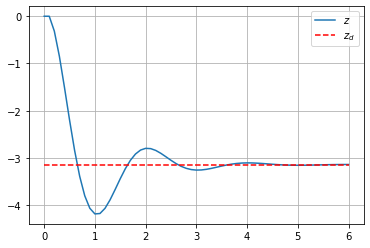

In [28]:
grid()
plot(time, x_log[:,0], label='$z$')
# desired
plot(time[[0,-1]], [θ_d, θ_d], 'r--', label='$z_d$')
legend()

## Draw simple box

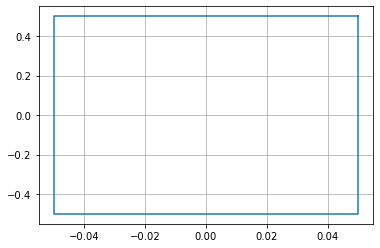

In [29]:
def box_points(w, h):
    points = np.zeros([5,3])
    points[0] = [ + w/2, 0, + h/2]
    points[1] = [ + w/2, 0, - h/2]
    points[2] = [ - w/2, 0, - h/2]
    points[3] = [ - w/2, 0, + h/2]
    points[4] = [ + w/2, 0, + h/2]
    return points

box = box_points(0.1, 1)  

plot(box[:,0], box[:,2])
grid()


### Box in SE(2)

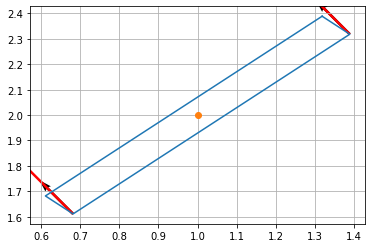

In [30]:
def box_se2(x, z, θ, u=[0,0], w=1, h=.1, ax=plt.axes()):
    points = box_points(w, h)
    # Rotation matrix
    R = [[cos(θ), 0, sin(θ)], 
         [0, 1, 0],
         [-sin(θ), 0, cos(θ)]]
    # Rotate
    points = [np.dot(R, p) for p in points]    
    points = array(points)
    
    # translate
    points[:,0] += x
    points[:,2] += z
    
    
    # propellers
    e1 = [1,0,0]    
    prop_x = array([sin(θ), sin(θ)])
    prop_z = array([cos(θ), cos(θ)])
        
    # Plot propellers
    px = points[1:3,0]
    pz = points[1:3,2]
    ax.quiver(px, pz, prop_x, prop_z, scale=7)
    
    ax.plot(points[:,0], points[:,2])
    # control input    
    ax.quiver(px, pz, u*prop_x, u*prop_z, scale=7, color='r')
    
 
x, z, θ = 1,2, -pi/4
box_se2(x, z, θ, [3,3], w=1, h=0.1)

plot(x,z, 'o')
grid()

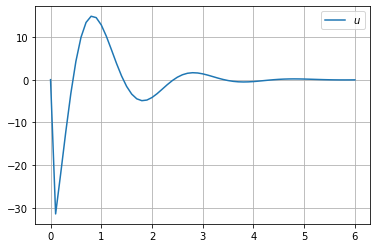

In [33]:
# Control inputs
u_log = array(u_log)
plot(time[:], u_log, label='$u$')
grid()
legend()

In [34]:
import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation import IPython_display    
from IPython.display import HTML
    


fig, ax = plt.subplots()


def animate(t):
    ax.clear()       
        
    θ = x_log[t,0]
    u = u_log[t]
    # box points
    box = box_se2(0, 0, θ,[0,u], w=1, h=0.1, ax=ax)

 
    # Initial conditions
    ax.plot([0], [0],  'o')
    ax.set_xlim((-1.5, 1.5))
    ax.set_ylim((-1.,1.))
    

anim = animation.FuncAnimation(fig, animate, frames=len(time), interval=60)
plt.close(fig)
HTML(anim.to_jshtml())



# Important
A problem is that most motors with propellers do not generate negative forces. If we constrain the force $f$ to be possitive, the control policy does not converge anymore. Instead, we can try using two motors. 

# Using two motors

# Orientation Control
The robot forces $f_1$ and $f_2$ generates a torque
$$
\tau = l (f_1 - f_2).
$$
The control input now has two elements $[f_1, f_2]=u$.

Using the Euler equation, we can derive the dynamics 
$$
\ddot\theta {I} = \tau.
$$

The dynamics is given by
$$
\ddot \theta = \frac{l}{{I}}(f_1-f_2).
$$

We propose the control input that divides the load between f_1 and f_2 equally,
$$
f_1 = \frac{\tau}{2l}
$$
and 
$$f_2= -\frac{\tau}{2l}$$

The total torque $\tau$ is computed based on a PD controller


In [50]:
# Desired angle
θ_d = pi/4
dθ_d = 0  # Desired angular velocity

# Gains
kp, kd = 10, 3

# arm
l = 1
I = 1

# Initial conditions
x = np.array([0.,0.])
dx = np.zeros(2)

x_log = [copy(x)]
u_log = [[0,0]]

for t in time[1:]:
    θ = x[0]
    dθ = x[1]
    
    # PD controller         
    τ = kp * (θ_d - θ) + kd * (dθ_d - dθ) # desired angular acceleration
    
    ## Torque
    f1 = τ / (2*l)
    f2 = -τ / (2*l)
    
    # Limit in the motors
    if f1<0:
        f1 = 0
    if f2<0:
        f2 = 0
        
    u = [f1, f2]
    
    # Dynamics
    dx[0] = x[1]
    dx[1] = (l / I) * (u[0] - u[1]) 
    
    x = simulate(Δt, x, dx)
    x_log.append(copy(x))
    u_log.append(copy(u))
    
x_log = array(x_log)
u_log = array(u_log)

In [51]:
import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation import IPython_display    
from IPython.display import HTML
    


fig, ax = plt.subplots()


def animate(t):
    ax.clear()       
        
    θ = x_log[t,0]
    u = u_log[t]
    # box points
    box = box_se2(0, 0, θ, u, w=1, h=0.1, ax=ax)

 
    # Initial conditions
    ax.plot([0], [0],  'o')
    ax.set_xlim((-1.5, 1.5))
    ax.set_ylim((-1.,1.))
    

anim = animation.FuncAnimation(fig, animate, frames=len(time), interval=60)
plt.close(fig)
HTML(anim.to_jshtml())

